In [0]:
!pip install --upgrade -q gspread

from google.colab import auth
auth.authenticate_user()

In [0]:
#IMPORT AUTH
from oauth2client.client import GoogleCredentials

import gspread
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d

gc = gspread.authorize(GoogleCredentials.get_application_default())

In [0]:
def editArr(x):
  a = np.array(x)
  for i in range(len(a)):
    a[i][0] = np.array(a[i][0].split(',')).astype(int)
  return a

def editArr2(x):
  a = np.array(x).astype(int)
  return a
  
#Digit_trn
worksheet_bintrn = gc.open('bindigit_trn').sheet1
rows_bintrn = worksheet_bintrn.get_all_values()
dataArr_bintrn = pd.DataFrame.from_records(rows_bintrn)
dataArr_bintrn = editArr(dataArr_bintrn)


#Digit_tst
worksheet_bintst = gc.open('bindigit_tst').sheet1
rows_bintst = worksheet_bintst.get_all_values()
dataArr_bintst = pd.DataFrame.from_records(rows_bintst)
dataArr_bintst = editArr(dataArr_bintst)


#Target_trn
worksheet_tartrn = gc.open('targetdigit_trn').sheet1
rows_tartrn = worksheet_tartrn.get_all_values()
dataArr_tartrn = pd.DataFrame.from_records(rows_tartrn)
dataArr_tartrn = editArr2(dataArr_tartrn)

#Target_tst
worksheet_tartst = gc.open('targetdigit_tst').sheet1
rows_tartst = worksheet_tartst.get_all_values()
dataArr_tartst = pd.DataFrame.from_records(rows_tartst)
dataArr_tartst = editArr2(dataArr_tartst)


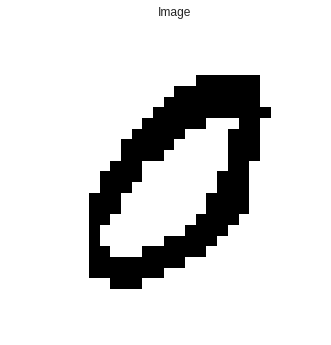

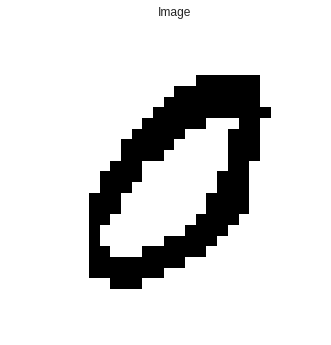

0


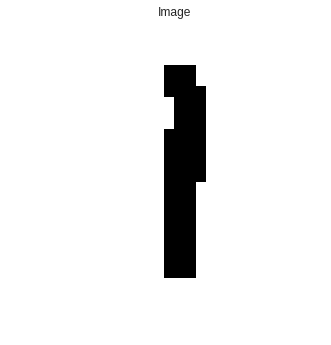

1


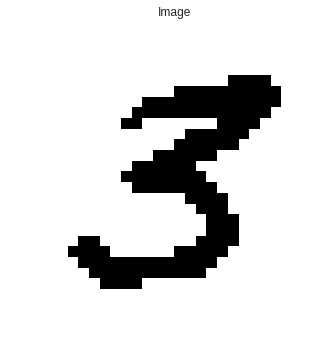

3


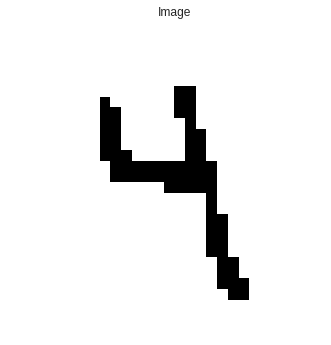

4


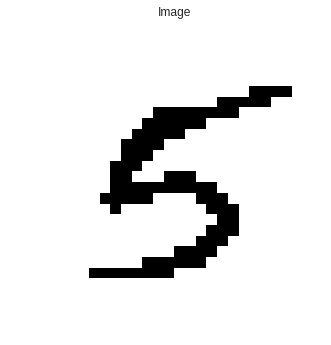

5


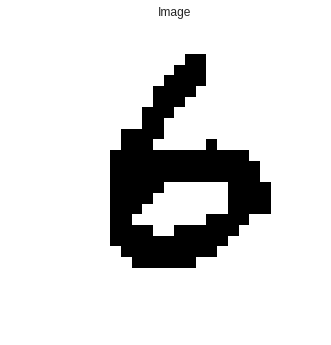

6


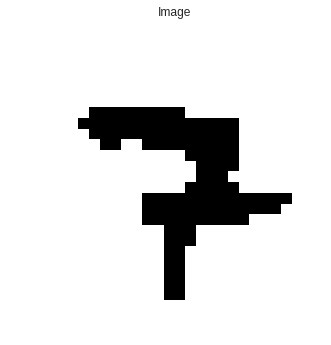

7


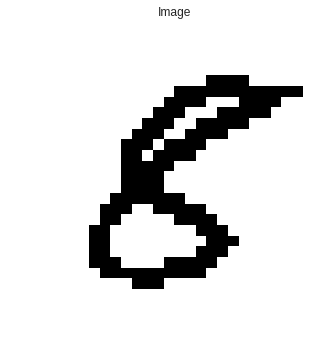

8


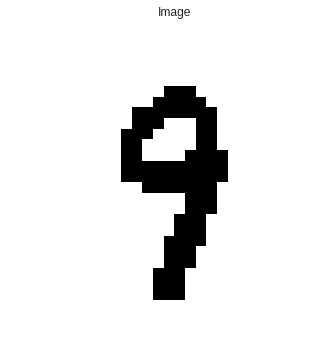

9


In [7]:
from matplotlib import pyplot as plt

def vis(x):
  a = x.reshape(28,28)
  plt.axis('off')
  plt.imshow(a, interpolation='nearest')
  plt.title('Image')
  plt.show()



allPatterns = [11,2,15,6,3,0,4,31,9]
vis(np.array(dataArr_bintrn[allPatterns[0],:][0]))

def visBig(x):
  n = len(x)
  nDiv = n/10
  f, axarr = plt.subplots(nDiv,nDiv)
  
  #f.axis('off')
  #plt.axis('off')
  for i in range(nDiv):
    for j in range(nDiv):
      a = x[i*5 + j].reshape(28,28)
      axarr[i,j].imshow(a)
      axarr[i,j].axis('off')
for i in range(len(allPatterns)):
  vis(np.array(dataArr_bintrn[allPatterns[i],:][0]))
  print(dataArr_tartrn[allPatterns[i],:][0])


Epoch number 0
Epoch number 1


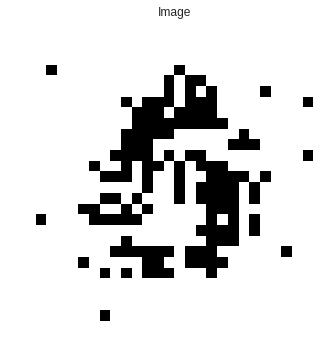

Epoch number 2
Epoch number 3
Epoch number 4
Epoch number 5


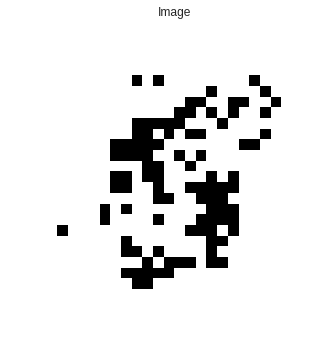

Epoch number 6
Epoch number 7
Epoch number 8
Epoch number 9
Epoch number 10


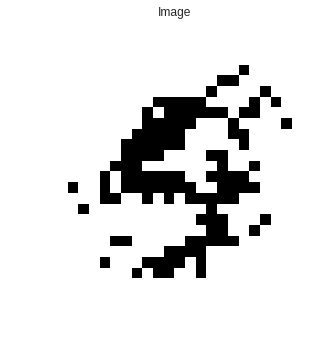

Epoch number 11
Epoch number 12
Epoch number 13
Epoch number 14
Epoch number 15


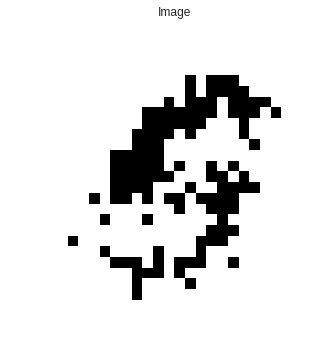

Epoch number 16
Epoch number 17
Epoch number 18
Epoch number 19
Epoch number 20


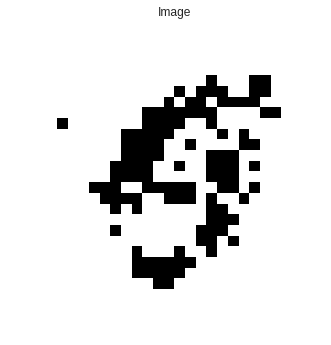

Epoch number 21
Epoch number 22
Epoch number 23
Epoch number 24
Epoch number 25


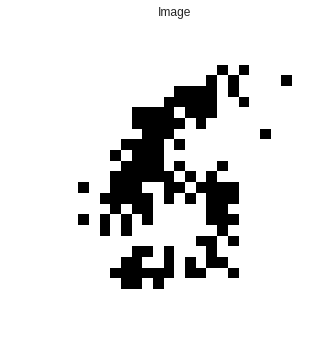

Epoch number 26
Epoch number 27
Epoch number 28
Epoch number 29
Epoch number 30
Epoch number 31
Epoch number 32
Epoch number 33
Epoch number 34
Epoch number 35
Epoch number 36
Epoch number 37
Epoch number 38
Epoch number 39
The mean squared error as a function of epochs


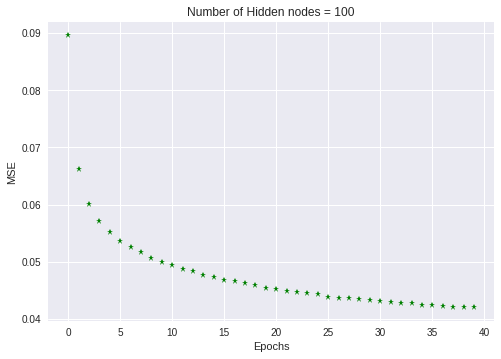

In [15]:
import numpy as np
import pandas as pd
import glob
import tensorflow as tf
from tensorflow.python.ops import control_flow_ops


## RBM

n_visible = 784
n_hidden  = 100
lr         = tf.constant(0.005, tf.float32) #The learning rate of our model

epochs = 40
batch = 2000


x  = tf.placeholder(tf.float32, [None, n_visible], name="x") #The placeholder variable that holds our data
#initialize the weight matrix with small (normally distributed) random values 
W  = tf.Variable(tf.random_normal([n_visible, n_hidden], 0.01), name="W") #The weight matrix that stores the edge weights
# with hidden and visible biases initialized to 0
bh = tf.Variable(tf.zeros([1, n_hidden],  tf.float32, name="bh")) #The bias vector for the hidden layer
bv = tf.Variable(tf.zeros([1, n_visible],  tf.float32, name="bv")) #The bias vector for the visible layer


def sample(probs):
    #Takes in a vector of probabilities, and returns a random vector of 0s and 1s sampled from the input vector
    return tf.floor(probs + tf.random_uniform(tf.shape(probs), 0, 1))

#This function runs the gibbs chain. We will call this function in two places:
#    - When we define the training update step
#    - When we sample our music segments from the trained RBM
def gibbs_sample(k):
    #Runs a k-step gibbs chain to sample from the probability distribution of the RBM defined by W, bh, bv
    def gibbs_step(count, k, xk):
        #Runs a single gibbs step. The visible values are initialized to xk
        hk = sample(tf.sigmoid(tf.matmul(xk, W) + bh)) #Propagate the visible values to sample the hidden values
        xk = sample(tf.sigmoid(tf.matmul(hk, tf.transpose(W)) + bv)) #Propagate the hidden values to sample the visible values
        return count+1, k, xk

    #Run gibbs steps for k iterations
    ct = tf.constant(0) #counter
    for i in range (k):
      [_,_,x_sample] = gibbs_step(ct,tf.constant(k),x)
    
    #This is not strictly necessary in this implementation, but if you want to adapt this code to use one of TensorFlow's
    #optimizers, you need this in order to stop tensorflow from propagating gradients back through the gibbs step
    x_sample = tf.stop_gradient(x_sample) 
    return x_sample

### Training Update Code
# Now we implement the contrastive divergence algorithm. First, we get the samples of x and h from the probability distribution
#The sample of x
x_sample = gibbs_sample(1) 
#The sample of the hidden nodes, starting from the visible state of x
h = sample(tf.sigmoid(tf.matmul(x, W) + bh)) 
#The sample of the hidden nodes, starting from the visible state of x_sample
h_sample = sample(tf.sigmoid(tf.matmul(x_sample, W) + bh)) 

#Next, we update the values of W, bh, and bv, based on the difference between the samples that we drew and the original values
size_bt = tf.cast(tf.shape(x)[0], tf.float32)
W_adder  = tf.multiply(lr/size_bt, tf.subtract(tf.matmul(tf.transpose(x), h), tf.matmul(tf.transpose(x_sample), h_sample)))
bv_adder = tf.multiply(lr/size_bt, tf.reduce_sum(tf.subtract(x, x_sample), 0, True))
bh_adder = tf.multiply(lr/size_bt, tf.reduce_sum(tf.subtract(h, h_sample), 0, True))
#When we do sess.run(updt), TensorFlow will run all 3 update steps
updt = [W.assign_add(W_adder), bv.assign_add(bv_adder), bh.assign_add(bh_adder)]

# dataArr_bintrn
# dataArr_bintst
# dataArr_tartrn
# dataArr_tartst
error = np.zeros([epochs])
with tf.Session() as sess:
    #First, we train the model
    #initialize the variables of the model
    init = tf.global_variables_initializer()
    sess.run(init)
    #Run through all of the training data num_epochs times
    for i in range(epochs):
        print("Epoch number " + str(i))
        localerror=np.zeros([batch]) ## SAME NUMBER AS 
        for j in range(batch): #len(dataArr_bintrn)): # Run only for 2000
            #print("Data point  " + str(j))

            x_train = np.array(dataArr_bintrn[j,:][0])
            x_train = [x_train]
            [_,label]=sess.run([updt,x_sample], feed_dict={x: x_train})
            
            localerror[j] = np.sum(0.5*(x_train-label)**2)/n_visible
        error[i] = np.sum(localerror)/batch
        
        if i == 1 or i == 5 or i == 10 or i == 15 or i == 20 or i == 25  :
          allPatterns = [11,2,8,15,6,3,0,4,31,9]
          tester = np.array(dataArr_bintrn[allPatterns[5],:][0])
          tester = [tester] #first data point, the number 6
          sample8 = gibbs_sample(1).eval(session=sess, feed_dict={x: tester})
          vis(sample8)
        
    #Now the model is fully trained, so let's make some music! 
    #Run a gibbs chain where the visible nodes are initialized to 0
    """
    allPatterns = [11,2,8,15,6,3,0,4,31,9]
    tester = np.array(dataArr_bintrn[allPatterns[0],:][0])
    tester = [tester] #first data point, the number 6
    sample0 = gibbs_sample(1).eval(session=sess, feed_dict={x: tester})
    vis(sample0)
    allPatterns = [11,2,8,15,6,3,0,4,31,9]
    tester = np.array(dataArr_bintrn[allPatterns[1],:][0])
    tester = [tester] #first data point, the number 6
    sample1 = gibbs_sample(1).eval(session=sess, feed_dict={x: tester})
    vis(sample1)
    allPatterns = [11,2,8,15,6,3,0,4,31,9]
    tester = np.array(dataArr_bintrn[allPatterns[2],:][0])
    tester = [tester] #first data point, the number 6
    sample2 = gibbs_sample(1).eval(session=sess, feed_dict={x: tester})
    vis(sample2)
    allPatterns = [11,2,8,15,6,3,0,4,31,9]
    tester = np.array(dataArr_bintrn[allPatterns[3],:][0])
    tester = [tester] #first data point, the number 6
    sample3 = gibbs_sample(1).eval(session=sess, feed_dict={x: tester})
    vis(sample3)
    allPatterns = [11,2,8,15,6,3,0,4,31,9]
    tester = np.array(dataArr_bintrn[allPatterns[4],:][0])
    tester = [tester] #first data point, the number 6
    sample4 = gibbs_sample(1).eval(session=sess, feed_dict={x: tester})
    vis(sample4)
    
    tester = np.array(dataArr_bintrn[allPatterns[5],:][0])
    tester = [tester] #first data point, the number 6
    sample5 = gibbs_sample(1).eval(session=sess, feed_dict={x: tester})
    vis(sample5)
    allPatterns = [11,2,8,15,6,3,0,4,31,9]
    tester = np.array(dataArr_bintrn[allPatterns[6],:][0])
    tester = [tester] #first data point, the number 6
    sample6 = gibbs_sample(1).eval(session=sess, feed_dict={x: tester})
    vis(sample6)
    allPatterns = [11,2,8,15,6,3,0,4,31,9]
    tester = np.array(dataArr_bintrn[allPatterns[7],:][0])
    tester = [tester] #first data point, the number 6
    sample7 = gibbs_sample(1).eval(session=sess, feed_dict={x: tester})
    vis(sample7)
    """
    
    #allPatterns = [11,2,8,15,6,3,0,4,31,9]
    #tester = np.array(dataArr_bintrn[allPatterns[9],:][0])
    #tester = [tester] #first data point, the number 6
    #sample9 = gibbs_sample(1).eval(session=sess, feed_dict={x: tester})
    #vis(sample9)
    """
    for i in range(len(allPatterns)):  
      print("printing index " + str(allPatterns[i]) + " image ")
      tester = np.array(dataArr_bintrn[allPatterns[i],:][0])
      tester = [tester] #first data point, the number 6
      sample = gibbs_sample(1).eval(session=sess, feed_dict={x: tester})
      vis(sample)
    """
    print("The mean squared error as a function of epochs")
    plt.figure(2)
    plt.title('Number of Hidden nodes = ' +str(n_hidden))
    plt.plot(error,'g*')
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
   
    wRbmPrint = sess.run(W)




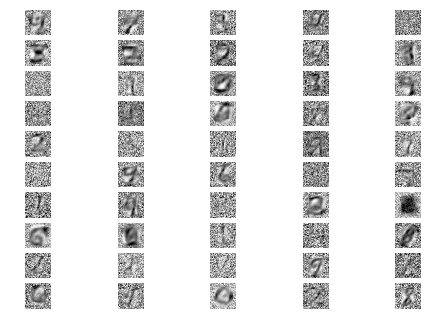

In [22]:
#visBig(wRbmPrint)
#50 nodes, 40 epochs

test = np.zeros((n_hidden,n_visible))
for i in range(n_hidden):
  for j in range(n_visible):
    test[i,j] = wRbmPrint[j,i]

  
  
def vis2(x):
  a = x.reshape(28,28)
  plt.axis('off')
  plt.imshow(a, interpolation='nearest')
  plt.title('Image')
  plt.show()


      
visBig(test)
#vis2(test)

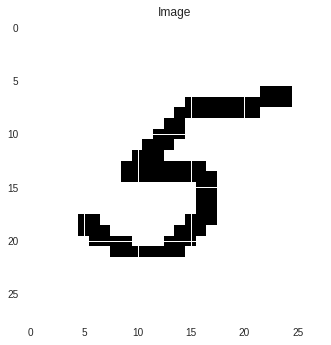

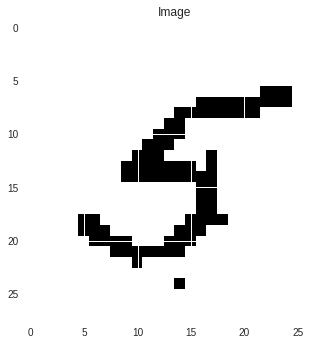

In [33]:
from matplotlib import pyplot as plt

def vis(x):
  a = x.reshape(28,28)
  plt.imshow(a, interpolation='nearest')
  plt.title('Image')
  plt.show()



#print(np.shape(sample))
#print(dataArr_tartrn[0])
vis(np.array(dataArr_bintrn[10,:][0]))

for i in range(len(sample)):
  vis(sample[i])

epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
epoch 31
epoch 32
epoch 33
epoch 34
epoch 35
epoch 36
epoch 37
epoch 38
epoch 39
RECONSTRUCT


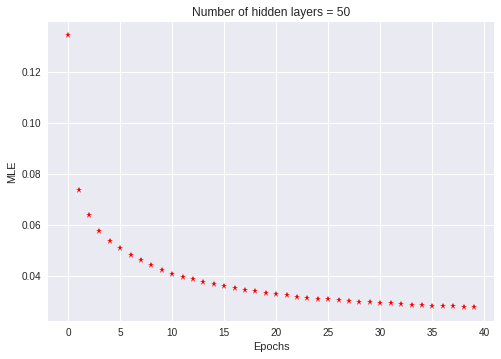

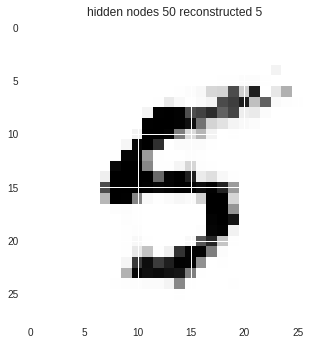

In [17]:
## Autoencoder
def vis2(x,s):
  a = x.reshape(28,28)
  plt.imshow(a, interpolation='nearest')
  plt.title(s)
  plt.show()

n_input = 784  #Image
n_hidden  = 50 #Hidden layer
lr         = tf.constant(0.005, tf.float32) #The learning rate of our model
epochs = 40 #10000
batch  = 2000 
display_step = 1000

x = tf.placeholder("float",[None,n_input])

weights = {
    'encoder_h1': tf.Variable(tf.random_normal([n_input, n_hidden])),
    'decoder_h1': tf.Variable(tf.random_normal([n_hidden, n_input])),
}
biases = {
    'encoder_b1': tf.Variable(tf.random_normal([n_hidden])),
    'decoder_b1': tf.Variable(tf.random_normal([n_input])),
}
    
def encoder(x):
    #Hidden layer sigmoid
    hid1 = tf.nn.sigmoid(tf.add(tf.matmul(x,weights['encoder_h1']), biases['encoder_b1']))
    return hid1
  
def decoder(x):
    hid1 = tf.nn.sigmoid(tf.add(tf.matmul(x,weights['decoder_h1']), biases['decoder_b1']))
    return hid1

    
#Model
encoder_op = encoder(x)
decoder_op = decoder(encoder_op)    

#Prediction
y_pred = decoder_op
y_true = x

loss = tf.reduce_mean(tf.pow(y_true-y_pred,2))
optimizer = tf.train.RMSPropOptimizer(lr).minimize(loss)

    
init = tf.global_variables_initializer()
    
## SESSION
allPatterns = [11,2,8,15,6,3,0,4,31,9]

with tf.Session() as sess:
    sess.run(init)
    #vis(dataArr_bintrn[1,:][0])
    error = np.zeros([epochs]) #
    for i in range(epochs):
      print("epoch " + str(i))
      local_error = np.zeros([batch])
      for j in range(batch):
        #arr = tf.get_variable('encoder_h1')
        #print(arr)
        x_train = np.transpose(np.array(dataArr_bintrn[j,:][0]))
      
        x_train = [x_train]
        
        _,l = sess.run([optimizer,loss], feed_dict ={x: x_train})
        local_error[j] = l
          
        # Display logs per step
       # if i % display_step == 0 :#or i == 1:
        #  print('Step %i: Loss: %f' % (i, l))
        
      error[i] = np.sum(local_error)/batch   
      #print("weights")
      #wPrint = sess.run(weights['decoder_h1'])
      #a = tf.get_variable('encoder_h1')
      #vis(np.array(wPrint))

      #print(wPrint)
      #print(a)
      #two = np.transpose(np.array(dataArr_bintrn[allPatterns[2],:][0]))
      #two = [two]
      #two_test = sess.run(decoder_op, feed_dict ={x: two})
      #vis2(two_test,"reconstructed " + str((dataArr_tartrn[allPatterns[2],:][0])) + " at epoch " + str(i))
          
    #Done with training
    #Reconstruct picture
    
    # WEIGHTS
    #vis(np.array(wPrint))
    wPrint = sess.run(weights['decoder_h1'])

    print("RECONSTRUCT")
    
    plt.figure(1)
    plt.plot(error,'r*')
    plt.title('Number of hidden layers = '+str(n_hidden))
    plt.xlabel('Epochs')
    plt.ylabel('MLE')
    # index of patterns 0,1,2,3,4,5,6,7,8,9
    plt.figure(2)
    #for i in range(len(allPatterns)):
    i = 5
    #vis2(np.array(dataArr_bintrn[allPatterns[i],:][0]),"original " + str((dataArr_tartrn[allPatterns[i],:][0])))
    ano_train = np.transpose(np.array(dataArr_bintrn[allPatterns[i],:][0]))
    ano_train = [ano_train]
    test_another = sess.run(decoder_op, feed_dict ={x: ano_train})
    vis2(test_another,"hidden nodes " + str(n_hidden) + " reconstructed " + str((dataArr_tartrn[allPatterns[i],:][0])))

    #array of random ones and zeros
    #print("Random")
    #tester = np.random.randint(2, size=(1, n_visible)) 
    #test_random = sess.run(decoder_op, feed_dict ={x: tester})
    #vis(test_random)
    #the original pattern
    #print("Original")
    #test_orig = sess.run(decoder_op, feed_dict ={x: x_train})
    #vis(test_orig)
    
    #the other pattern of 6
    #print("Another")
    #ano_train = np.transpose(np.array(dataArr_bintrn[5,:][0]))
    #ano_train = [ano_train]
    #test_another = sess.run(decoder_op, feed_dict ={x: ano_train})
    #vis(test_another)
    
    

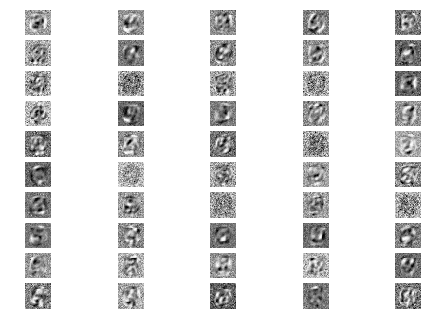

In [20]:

def visBig(x):
  n = len(x)
  nDiv = n/10
  f, axarr = plt.subplots(10,nDiv)
  
  #f.axis('off')
  #plt.axis('off')
  for i in range(10):
    for j in range(nDiv):
      a = x[i*5 + j].reshape(28,28)
      axarr[i,j].imshow(a)
      axarr[i,j].axis('off')

visBig(wPrint)

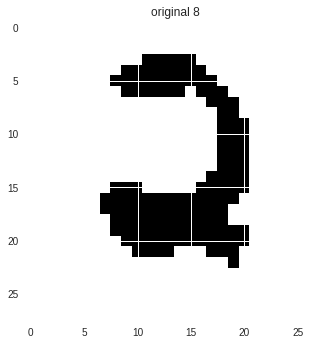

In [81]:


vis2(np.array(dataArr_bintrn[8,:][0]),"original " + str((dataArr_tartrn[allPatterns[8],:][0])))
